# Definition

In [1]:
%load_ext autoreload
%aimport libs.audio
%aimport libs.learning
%autoreload 1
# reload "audio.py,learning.py" before every execution. 
#reference : https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=reload

In [2]:
import librosa
import pyworld as pw
import scipy
import numpy as np
from pathlib import Path
from joblib import Parallel,delayed
from sklearn.preprocessing import normalize
import pickle
from IPython import embed
from tqdm import tqdm_notebook as tqdm
import IPython.display
import matplotlib.pyplot as plt
from datetime import datetime

import fastai as fastai
from fastai.vision import *
from fastai.vision.data import *
from fastai.vision.gan import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.callbacks.tensorboard import *
from torchvision.models import resnet18

from libs.audio import *
from libs.learning import *


In [3]:
model_ver = "006"

path=Path("D:/bulk/dataset/audio/Anonymous-VC")
path_raw =            path/"10_raw_yuduki-yukari"
path_prep_original  = path/"23_prep_original_3sec"
path_prep_anonymous = path/"33_prep_anonymous_3sec"
path_gen            = path/("43_gen_3sec_"+model_ver)
print(path)

path_prep_original.mkdir(parents=False, exist_ok=True)
path_prep_anonymous.mkdir(parents=False, exist_ok=True)
path_gen.mkdir(parents=False, exist_ok=True)

mtrace = GPUMemTrace()
tboard_path = Path('./runs')/model_ver


D:\bulk\dataset\audio\Anonymous-VC


In [4]:
# utility functions
def modelname(s:str):
    return f'{model_ver}_{s}_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
def latest(modelname_pat:str,model_ver=model_ver,p:Path=path/'models'):
    'search the latest file which matches `model_ver`_`modelname_pat` pattern in `p`,returns filename without extension.'
    pat=f'**/{model_ver}_{modelname_pat}*'
    list_of_paths = p.glob(pat)
    ret = max(list_of_paths, key=lambda p: p.stat().st_ctime).stem
    print(f"""search latest file of : {pat}
     from {p}
    found:{ret}""")
    return ret



# generator func

In [5]:
def get_data(bs,x_path,y_path):
    src = PklImageImageList.from_folder(x_path,extensions=[".pkl"]) \
            .split_by_rand_pct(0.1, seed=42)
    data = (src.label_from_func(lambda x: y_path/x.name)) \
        .databunch(bs=bs,num_workers=0)
            # num_workers=0 is workaround for Broken Pipeline (Windows, Pytorch, 2019.8)
            # refer : https://forums.fast.ai/t/brokenpipeerror-using-jupyter-notebook-lesson-1/41090/4

#            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
#             .normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
bs=2
# data_gen = get_data(bs,path_prep_original,path_prep_original)
data_gen = get_data(bs,path_prep_anonymous,path_prep_original)
data_gen.one_batch()[0].shape

torch.Size([2, 3, 128, 768])

In [7]:
arch = models.resnet18
wd = 1e-3
y_range = (0.,1.)
loss_gen = L1LossFlat()

In [8]:
class EpockImshower(LearnerCallback):
    def on_epoch_end(self, epoch: int, smooth_loss: Tensor, last_metrics: MetricsList, **kwargs: Any) -> bool:
        self.learn.show_results(rows=1,showtext=f"epoch{str(epoch)}")
    
def create_gen_learner():
#     return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
#                          self_attention=True, y_range=y_range, loss_func=loss_gen)
    learner = unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=None, loss_func=loss_gen)
    
    # UNET cannot show on Tensorboard.(SummaryWriter is not supported)
#     learner.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=tboard_path, name='Smthng'))
#     learner.callback_fns.append(EpockImshower)
    learner.path=path
    return learner


In [9]:
learn_gen = create_gen_learner()
learn_gen.unfreeze();

# critic func

In [16]:
def get_crit_data(classes, bs):
#     src = PklImageList.from_folder(path, include=classes,extensions=[".pkl"]).split_by_rand_pct(0.1, seed=42)
    src = PklImageList.from_folder(path, include=classes,extensions=[".pkl"]).split_by_rand_pct(0.99, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = ll.databunch(bs=bs,num_workers=0)  #.normalize(imagenet_stats)
    data.c = 3
    return data
data_crit = get_crit_data([path_gen.name, path_prep_original.name], bs=bs)

In [17]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [18]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [19]:
def my_accuracy_thresh_expand(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy after expanding `y_true` to the size of `y_pred`."
    if sigmoid: y_pred = y_pred.sigmoid()
    embed()
    return ((y_pred>thresh).byte()==y_true[:,None].expand_as(y_pred).byte()).float().mean()
learn_crit = create_critic_learner(data_crit, my_accuracy_thresh_expand)
learn_crit.path=path
learn_crit.unfreeze()

# train GAN

In [20]:
gc.collect()
wd=1e-3
bs=1

In [27]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.path=path

In [28]:
learn.load('006_gan2  20C1e-4_20190907-160739')

GANLearner(data=ImageDataBunch;

Train: LabelList (7936 items)
x: PklImageImageList
Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768)
y: PklImageList
Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768)
Path: D:\bulk\dataset\audio\Anonymous-VC\33_prep_anonymous_3sec;

Valid: LabelList (881 items)
x: PklImageImageList
Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768)
y: PklImageList
Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768),Image (3, 128, 768)
Path: D:\bulk\dataset\audio\Anonymous-VC\33_prep_anonymous_3sec;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): 

input0


prediction0


target0


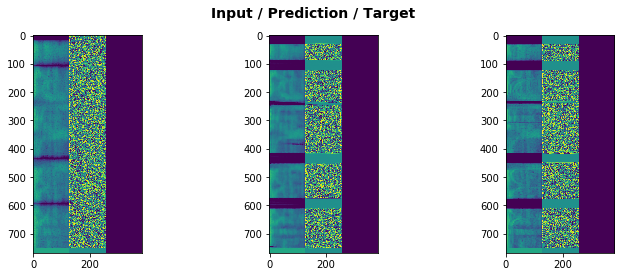

In [30]:
learn_gen.show_results(rows=1)

In [33]:
#learn.show_results(rows=1)